# Yelp API Webscraping

In [1]:
import pandas as pd 
import numpy as np
import json
import requests
import time, datetime
import math

import matplotlib.pyplot as plt
import matplotlib.path as mplpath    # for gathering coordinates inside LA

## Using the Yelp Fusion API

Description about how to use Yelp API

In [2]:
# NOTHING IN THIS CELL NEEDS TO GET CHANGED 
# IF YOU HAVE YOUR API KEY IN 'creds.json' IN ./Assets

# format your json file as a dictionary containing api key with DOUBLE QUOTES
# {"api": "your_super_long_api_key"}
CREDS_FILE = open('../Assets/creds.json')

# load credentials into variable
YELP_CREDENTIALS = json.loads(CREDS_FILE.read())
API_KEY = YELP_CREDENTIALS['api']
HEADERS = {'Authorization': 'Bearer %s' % API_KEY}

# this is the url we use to make broad business searches
# https://www.yelp.com/developers/documentation/v3/business_search

URL = 'https://api.yelp.com/v3/businesses/search'

### Issues:
- each Yelp request returns a max of 1000 results to the user
- we wanted to grab all listings as efficiently as possible
- for search radii that returned more than 1000, we split the circle into 7 smaller circles, which represents a simple, efficient arrangement to ensure that the original area is completely covered.  

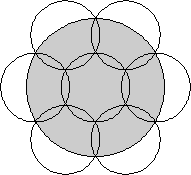

## Function Walkthrough

- `la_county_yelp_scanner()`
    - `get_la_county_points()`
    - `get_businesses()`
        - `call_and_delay()`
        - `add_businesses()`
        - `shotgun()`
            - `get_six_points()`
                - `get_earth_radius()`
                - `get_new_point()`
            - `get_businesses()`
            
### `la_county_yelp_scanner()`
This is the main function that gets all listings in LA County and returns a dataframe and csv containing listing information.

### `get_la_county_points()`
This function calculates all hexagonally-arranged latitude and longitude coordinates optimized for a specific search radius, in meters.

### `get_businesses()`
For each point in `get_la_county_points()`, this function uses: 
- `call_and_delay()`, which calls the API and adds a delay to prevent exceeding the query-per-second (QPS) limit, and
- `add_businesses()` to add the API response from `call_and_delay()` to a list container.  

If total number of listings in the given search area exceeds 1000, then it calls `shotgun()` instead.

### `shotgun()`
Splits the search area into seven smaller search areas with identical radii. Uses:
- `get_six_points()`, which repeats `get_earth_radius()` and `get_new_point()` six times, and then:
- runs `get_businesses()` for each of the seven smaller circles.

This introduces an iterative process where, in the case that one of the seven new circles returns more than 1000 listings, `shotgun()` will be repeated.

### latitude-longitude functions

In [3]:
# https://en.wikipedia.org/wiki/Earth_radius

def get_earth_radius(lat):
    '''
    Calculates radius of Earth at given latitude, assuming 
    oblate spheroid geometry.
    
    Arguments:
        lat (float):        latitude, in decimal degrees
        
    Returns:
        radius (float), in meters
    '''
    
    lat = math.radians(lat)
    
    # geocentric radius formula
    a = 6_378_137               # equatorial radius
    b = 6_356_752.3             # polar radius
    numer = (a**2 * math.cos(lat))**2 + (b**2 * math.sin(lat))**2
    denom = (a * math.cos(lat))**2 + (b * math.sin(lat))**2
    
    return math.sqrt(numer / denom) 

In [4]:
def get_new_point(distance, bearing, lon=0, lat=0):
    '''
    Generates destination geographic coordinate based on 
    starting point, spherical distance traveled, and bearing.
    Use only for short distances (< 100_000).
    
    Arguments:
        distance (float):   distance to closest point, in meters
        bearing (float):    direction from starting point, in decimal degrees
        lat (float):        starting latitude, in decimal degrees
        lon (float):        starting longitude, in decimal degrees
        
    Returns:
        tuple containing new coordinates, in decimal degrees
        
    Function dependencies:
        get_earth_radius()
    '''
    er = get_earth_radius(lat)
    
    # converting to radians
    bearing = math.radians(bearing)
    lat     = math.radians(lat)
    lon     = math.radians(lon)
    
    # formulae taken from https://www.movable-type.co.uk/scripts/latlong.html
    lat2 = math.asin(math.sin(lat) * math.cos(distance / er)
           + math.cos(lat) * math.sin(distance / er) * math.cos(bearing))
    
    lon2 = lon + math.atan2(
           math.sin(bearing) * math.sin(distance / er) * math.cos(lat),
           math.cos(distance / er) - math.sin(lat) * math.sin(lat2))
    
    return math.degrees(lon2), math.degrees(lat2)

In [5]:
# picking seven smaller circles to "equal" one big circle
# https://en.wikipedia.org/wiki/Haversine_formula
# https://stackoverflow.com/questions/639695/
# https://stackoverflow.com/questions/7222382/
# https://www2.stetson.edu/~efriedma/circovcir/

def get_six_points(distance, lon=0, lat=0, rot=0):
    '''
    Generates 6 additional geographic coordinates hexagonally 
    arranged some distance from starting point.
    
    Arguments:
        distance (float):   distance to closest point, in meters
        lat1 (float):       starting latitude, in decimal degrees
        lon1 (float):       starting longitude, in decimal degrees
        rot (float):        rotational offset, in decimal degrees 
                            (recommended range -30 to 30)
        
    Returns:
        list of dictionaries with {'latitude': lat2, 'longitude': lon2}, 
        excluding starting point
        
    Function dependencies:
        get_new_point()
        get_earth_radius()
    '''    
    points = []
    
    # six directions
    bearings = [math.radians(deg) for deg in range(rot, 360, 60)]

    for bearing in bearings:
        point = {}
        lon2, lat2 = get_new_point(distance, bearing, lon=lon, lat=lat)
        point['longitude'] = lon2
        point['latitude'] = lat2
        points.append(point)

    return points

In [6]:
# https://gis.stackexchange.com/questions/183248/

def get_la_county_points(radius):
    '''
    Grabs businesses using get_businesses(), but narrows search 
    radius and aggregates with six additional search queries 
    to circumvent 1000-business limit imposed by the Yelp API.
    
    Arguments:
        radius (float):     search radius to optimize for,
                            in meters
        
    Returns:
        a list containing hexagonally arranged coordinates
        to search over
    '''
    distance = radius * math.sqrt(3)
    
    # see appendix for explanation
    county_bounds = json.loads(open('../Assets/la_county_coordinates.json').read())
    bounds = county_bounds['geometries'][0]['coordinates'][0][0]
    # path for matplotlib method
    boundary = mplpath.Path(bounds)
    
    LATMIN = min([ele[1] for ele in bounds])
    LATMAX = max([ele[1] for ele in bounds])
    
    LONMIN = min([ele[0] for ele in bounds])
    LONMAX = max([ele[0] for ele in bounds])
    
    # start at "lower-left" corner of rectangle
    lat = LATMIN
    lon = LONMIN
    
    points = [[lon, lat]]
    
    # we will "scan" the rectangle from left-to-right
    # bottom-to-top
    while lat < LATMAX:
        
        # here to start the scan at the beginning of each latitude
        startlat = lat
        startlon = lon
        
        # if we haven't reached the top yet
        while lon < LONMAX:
            # scan to the right
            lon, lat = get_new_point(distance, 90, lon=lon, lat=lat)
            points.append([lon,lat])
        
        # offset the next row for optimal hexagonal packing
        lon, lat = get_new_point(distance, -30, lon=startlon, lat=startlat)
        
        # if we are outside the border of LA county
        if lon < LONMIN:
            lon, lat = get_new_point(distance, 30, lon=startlon, lat=startlat)
            
        # add the point
        points.append([lon,lat])
        
    # boolean mask if the points in our rectangle are within LA county
    inside = boundary.contains_points(points)
    
    new_points = []
    
    # if true, add to newpoints
    for i, ins in enumerate(inside):
        if ins:
            new_points.append(points[i])
        
    return new_points

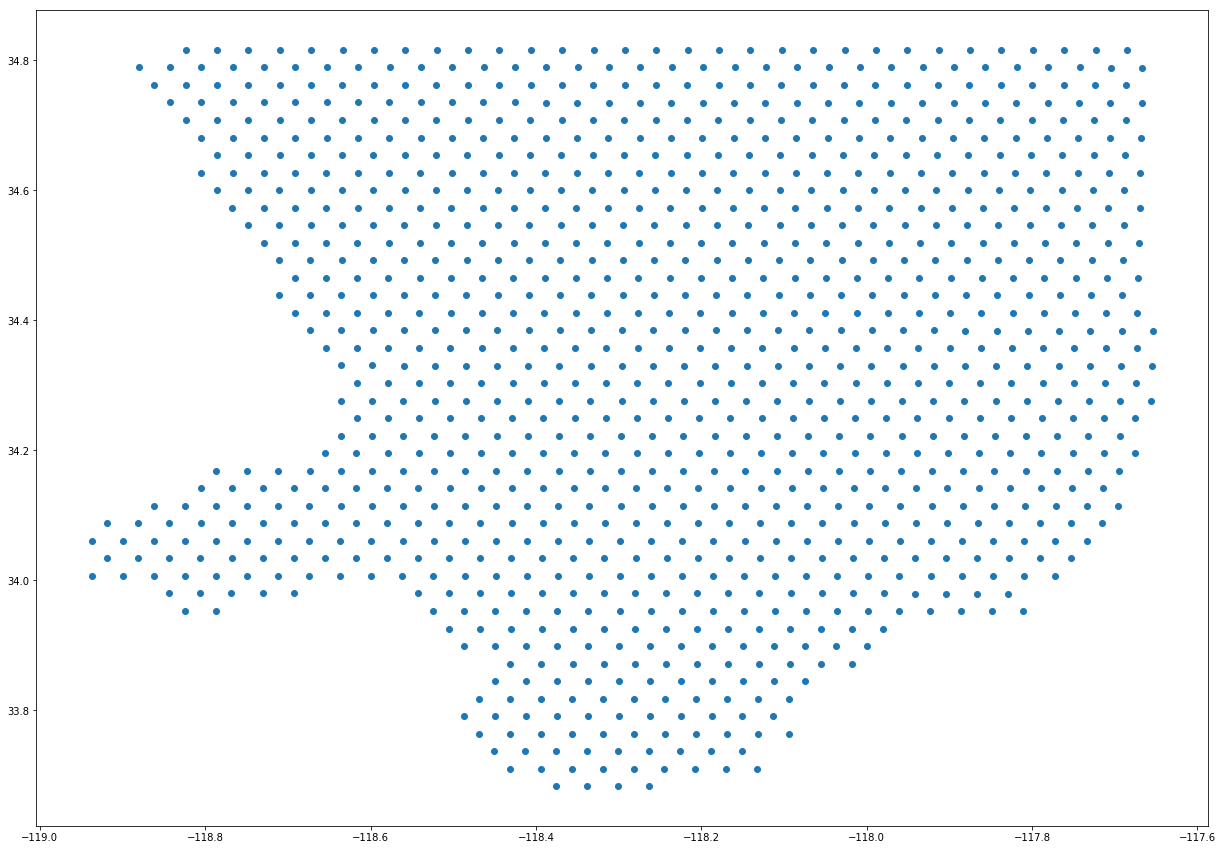

In [7]:
points = get_la_county_points(2000)

plt.figure(figsize=(21, 15))
lon = [ele[0] for ele in points]
lat = [ele[1] for ele in points]
plt.scatter(x=lon, y=lat)

### individual action functions

In [8]:
def add_businesses(response, business_list):
    '''
    Adds businesses to a list container.
    Not designed to be used alone.
    
    Arguments:
        response:       the API request object
        business_list:  an empty (or existing) list container
        
    Returns:
        the modified list container
    '''
    # businesses are listed under 'businesses' key
    bus_obj = response.json()['businesses']

    for i, business in enumerate(list(bus_obj)):

    # each dictionary will contain all of the desired information
    # from each business
        business_dict = {}
        
        # only grab business info if price is listed
        if 'price' in bus_obj[i].keys():
            business_dict['id']           = business['id']
            business_dict['latitude']     = business['coordinates']['latitude']
            business_dict['longitude']    = business['coordinates']['longitude']
            business_dict['price']        = business['price']
            business_dict['review_count'] = business['review_count']
            business_dict['rating']       = business['rating']
            business_dict['zip_code']     = business['location']['zip_code']
            business_dict['city']         = business['location']['city']
            business_dict['alias']        = business['alias']

            num_categories = len(businesses_object[i]['categories'])
            category_list = []
            for j in range(num_categories):
                category = businesses_object[i]['categories'][j]['alias']
                category_list.append(category)
                business_dict['category'] = category_list
            
            business_list.append(business_dict)
        
    return business_list

In [9]:
def call_and_delay(url, headers, params, sleep=0.25):
    '''
    Calls the API and induces a delay to reduce QPS.
    
    Arguments:
        url:            url of API
        headers:        headers, which includes API key
        params:         dictionary of parameters of search
        sleep:          induced delay, in seconds
                        (estimated max QPS of five per second)
        
    Returns:
        the response object from the API call
    '''
    response = requests.get(url, headers=headers, params=params)
    time.sleep(sleep)
    
    code = response.status_code
    
    # if things go well
    if code == 200:
        return response
    
    # if things don't go well
    else:
        print(f'! ! ! ! ! ! ! ! ! ! ! ! error code {response.status_code} ! ! ! ! ! ! ! ! ! ! ! !')
        # code of 429 means our daily limit has been reached
        # {429} interrupts the function upstream
        if code == 429:
            return 429
        
        # we can usually get around other errors by waiting
        elif (code >= 500):
            time.sleep(5)
            response = requests.get(url, headers=headers, params=params)
            time.sleep(sleep)
            return response
        
        # don't attempt to add businesses if we throw other errors
        else:
            time.sleep(5)
            pass

In [10]:
def get_businesses(radius, lon=0, lat=0, sleep=0.25, layer=0):
    '''
    Grabs as many businesses as allowed by the Yelp API given 
    geographic coordinates and search radius.
    
    Arguments:
        radius (float):     search radius, in meters
        lon (float):        longitude, in decimal degrees
        lat (float):        latitude, in decimal degrees
        sleep (float):      induced delay, in seconds
                            (estimated max QPS of five per second)
        layer (int):        only here to format the print output
                            of the scanner. changes aren't necessary.
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
        shotgun()
    '''
    # for formatting
    layer += 1
    bar = '===' * layer
    
    # Yelp doesn't like float radii
    radius = int(radius)
    
    # empty container to hold businesses
    businesses = []
    
    params = {
        'limit': 50, 
        'latitude': lat,
        'longitude': lon,
        'radius': radius,
        'offset': 0,
        'sort_by': 'distance'
    }

    # call the API
    response = call_and_delay(URL, HEADERS, params, sleep=sleep)
    
    # if we reach our max daily API limit, interrupt parent function
    if response == 429:
        return 429
    
    total = response.json()['total']
    
    # if search query exceeds 1000 max, initiate shotgun()
    if total > 1000:
        print(f'caution: query returns approximately {round(total, -2)} listings.')
        businesses = shotgun(radius, lon=lon, lat=lat, sleep=sleep, layer=layer)
        return businesses
    
    # gather info normally
    else:
        # add the first n <= 50 businesses
        add_businesses(response, businesses)
        
        # loop through offsets
        if total > 50:
        
            # only loop through offsets to the total number of listings
            for offset in range(50, total, 50):
                # update offset in search parameters
                params['offset'] = offset
                response = call_and_delay(URL, HEADERS, params, sleep)

                add_businesses(response, businesses)

                # just a little sanity check
                if offset % 100 == 0:
                    print(f'{bar} {offset} out of {total}')
            
        print(f'{bar} sub-search of {total} listings finished!')
        return businesses

### aggregate functions

In [11]:
def shotgun(radius, lon=0, lat=0, rot=0, sleep=0.25, layer=1):
    '''
    Grabs businesses using get_businesses(), but narrows search 
    radius and aggregates with six additional search queries 
    to circumvent 1000-business limit imposed by the Yelp API.
    
    Arguments:
        radius (float):     search radius to emulate, in meters
        lon (float):        longitude, in decimal degrees
        lat (float):        latitude, in decimal degrees
        rot (float):        rotational offset, in decimal degrees 
                            (recommended range -30 to 30)
        
    Returns:
        a list containing dictionaries of each business listing
    '''
    # for formatting
    layer += 1
    bar = '===' * layer
    
    businesses = []
    
    # initiate list of points to search
    points = [{'longitude': lon, 'latitude': lat}]
    
    # see appendix for an explanation
    distance = radius * math.sqrt(3) / 2
    points.extend(get_six_points(distance, 
                                 lon=lon, 
                                 lat=lat, 
                                 rot=rot))
    small_radius = distance / math.sqrt(3)
    
    print('attempting shotgun')

    # loop through each of the seven points using the smaller radius
    for i, point in enumerate(points):
        # to show which subradius we are searching through
        print(f'{bar} {i+1} of {len(points)}')
        pellet = get_businesses(small_radius,
                                lon=point['longitude'], 
                                lat=point['latitude'], 
                                sleep=sleep, 
                                layer=layer)
        businesses.extend(pellet)

    return businesses

In [12]:
# https://stackoverflow.com/questions/9427163/

def remove_duplicates(list_of_dictionaries):
    '''
    Removes duplicate dictionaries in the businesses list 
    by matching business ID.
    
    Arguments:
        list_of_dictionaries:       the list containing 
                                    business dictionaries
        
    Returns:
        a modified list without duplicate entries
    '''    
    # a set ignores duplicates
    seen = set()
    new_list = []
    
    for dictionary in list_of_dictionaries:
        # grab the id
        i = dictionary['id']
        
        # if we haven't seen the id yet, add it to the set
        if i not in seen:
            seen.add(i)
            # and then add the dictionary to the new list
            new_list.append(dictionary)
            
    # otherwise, we ignore
    print(f'{len(new_list)} unique listings from {len(list_of_dictionaries)} aggregated results')
    return new_list

In [13]:
def la_county_yelp_scanner(radius, save=True, start=0, end=-1, sleep=0.25):
    '''
    Grabs listings from a set of coordinates within LA county.
    
    Arguments:
        radius (float):     search radius, in meters
        start (int):        where to start our loop
        end (float):        where to end our loop
        sleep (float):      induced delay, in seconds
                            (estimated max QPS of five per second)
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
        shotgun()
    '''
    # just because it takes such a long time
    start_time = time.time()
    
    # grab all the points within LA county
    points = get_la_county_points(radius)
    num_points = len(points)
    
    if start < 0:
        start = 0
    elif start < 1:
        start = int(start * num_points)
    else:
        start = int(start)
    
    if end < 0:
        end = len(points)
    elif end < 1:
        end = int(end * num_points)
    else:
        end = int(end)
        
    if start > end:
        end = start + end
    
    if end > num_points:
        end = num_points
        
    print(f'''
            ==================================================================
            
            gathering listings from {num_points} coordinates in LA county
            
            ==================================================================            
            ''')
    
    businesses = []
    error_tracker = None
    
    for i in range(start, end):
        
        if i % int(num_points / 10) == 0:
            print(f'============ {i} out of {num_points} ============')
        
        point = points[i]
        
        # points are [longitude, latitude]
        b = get_businesses(radius, lon=point[0], lat=point[1], sleep=sleep)
        
        # there is a high chance we will reach our max call limit
        # with this function. for that reason, we wanted to add an
        # option to resume the function using another API key.
        if b == 429:
            error_tracker = {'radius': radius, 'error_info': {}}
            error_tracker['error_info']['marker']    = start + i
            error_tracker['error_info']['latitude']  = point[0]
            error_tracker['error_info']['longitude'] = point[1]
            error_tracker['error_info']['sleep']     = sleep
            
            print(f'''
            ==================================================================
            
            use another API key to re-run the code with the following arguments:
            
            la_county_yelp_scanner({radius}, start={start + i}, end={end}, sleep={sleep})
            
            ==================================================================            
            ''')
            
            return businesses, error_tracker
        
        # adds businesses if things go well
        businesses.extend(b)
    
    # removes duplicate entries from overlapping search queries
    businesses = remove_duplicates(businesses)
    
    if len(businesses) == 0:
        print('please consider widening your search parameters.')
    
    else:        
        businesses = pd.DataFrame(businesses)

        # Saves the business dataframe to a csv file with current time
        if save:
            now = datetime.datetime.now()
            now_formatted = now.strftime("%Y-%m-%d_%H_%M")
            businesses_path = f'../data/{radius}_{start}_{end}_businesses{now_formatted}.csv'
            businesses.to_csv(businesses_path,index=False)
            
        end_time = time.time()
        elapsed = end_time - start_time

        print(f'elapsed time: {round(elapsed / 60, 1)} min.')
        print(f'overall efficiency: {round(elapsed / len(businesses) * 1000, 1)} seconds per 1000 listings.')

        return businesses, error_tracker

In [14]:
# b, e = la_county_yelp_scanner(4000, start=0, end=-1, sleep=0.3)

## optional functions

In [15]:
def get_coordinates(zipcode):
    '''
    Converts a five-digit USPS zip code to geographic coordinates.
    
    Arguments:
        zipcode:            a five-digit string or integer
        
    Returns:
        a tuple containing (longitude, latitude), in decimal degrees
    ''' 
    zipcode = str(zipcode)
    zip_coords = json.loads(open('../Assets/zip_code_coordinates.json').read())
    if len(zipcode) == 5 and zipcode.isnumeric():
        latitude = zip_coords[zipcode]['latitude']
        longitude = zip_coords[zipcode]['longitude']
        
    return longitude, latitude